In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm

In [2]:
class Agent(object):
    
    def __init__(self, bandit, policy, prior=0, gamma=None):
        self.policy = policy
        self.k = bandit.k
        self.prior = prior
        self.gamma = gamma
        self._value_estimates = prior*np.ones(self.k)     #for value estimation
        self.action_attempts = np.zeros(self.k)
        self.t = 0
        self.last_action = None

    def __str__(self):
        return 'f/{}'.format(str(self.policy))

    def reset(self):
        self._value_estimates[:] = self.prior
        self.action_attempts[:] = 0
        self.last_action = None
        self.t = 0

    def choose(self):
        action = self.policy.choose(self)
        self.last_action = action
        return action

    def observe(self, reward):
        self.action_attempts[self.last_action] += 1

        if self.gamma is None:
            g = 1 / self.action_attempts[self.last_action]
        else:
            g = self.gamma
        q = self._value_estimates[self.last_action]

        self._value_estimates[self.last_action] += g*(reward - q)
        self.t += 1

    @property
    def value_estimates(self):
        return self._value_estimates

In [3]:
class GradientAgent(Agent):

    def __init__(self, bandit, policy, prior=0, alpha=0.1, baseline=True):
        super(GradientAgent, self).__init__(bandit, policy, prior)
        self.alpha = alpha
        self.baseline = baseline
        self.average_reward = 0

    def __str__(self):
        return 'g/\u03B1={}, bl={}'.format(self.alpha, self.baseline)

    def observe(self, reward):
        self.action_attempts[self.last_action] += 1

        if self.baseline:
            diff = reward - self.average_reward
            self.average_reward += 1/np.sum(self.action_attempts) * diff

        pi = np.exp(self.value_estimates) / np.sum(np.exp(self.value_estimates))

        ht = self.value_estimates[self.last_action]
        ht += self.alpha*(reward - self.average_reward)*(1-pi[self.last_action])
        self._value_estimates -= self.alpha*(reward - self.average_reward)*pi
        self._value_estimates[self.last_action] = ht
        self.t += 1

    def reset(self):
        super(GradientAgent, self).reset()
        self.average_reward = 0

In [4]:
class BetaAgent(Agent):
    
    def __init__(self, bandit, policy, ts=True):
        super(BetaAgent, self).__init__(bandit, policy)
        self.n = bandit.n
        self.ts = ts
        self.model = pm.Model()
        with self.model:
            self._prior = pm.Beta('prior', alpha=np.ones(self.k),
                                  beta=np.ones(self.k), shape=(1, self.k),
                                  transform=None)
        self._value_estimates = np.zeros(self.k)

    def __str__(self):
        if self.ts:
            return 'b/TS'
        else:
            return 'b/{}'.format(str(self.policy))

    def reset(self):
        super(BetaAgent, self).reset()
        self._prior.distribution.alpha = np.ones(self.k)
        self._prior.distribution.beta = np.ones(self.k)

    def observe(self, reward):
        self.action_attempts[self.last_action] += 1

        self.alpha[self.last_action] += reward
        self.beta[self.last_action] += self.n - reward

        if self.ts:
            self._value_estimates = self._prior.random()
        else:
            self._value_estimates = self.alpha / (self.alpha + self.beta)
        self.t += 1

    @property
    def alpha(self):
        return self._prior.distribution.alpha

    @property
    def beta(self):
        return self._prior.distribution.beta

In [5]:
class MultiArmedBandit(object):
    
    def __init__(self, k):
        self.k = k
        self.action_values = np.zeros(k)
        self.optimal = 0

    def reset(self):
        self.action_values = np.zeros(self.k)
        self.optimal = 0

    def pull(self, action):
        return 0, True

In [6]:
class GaussianBandit(MultiArmedBandit):
    
    def __init__(self, k, mu=0, sigma=1):
        super(GaussianBandit, self).__init__(k)
        self.mu = mu
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.action_values = np.random.normal(self.mu, self.sigma, self.k)
        self.optimal = np.argmax(self.action_values)

    def pull(self, action):
        return (np.random.normal(self.action_values[action]),
                action == self.optimal)

In [7]:
class BinomialBandit(MultiArmedBandit):
    
    def __init__(self, k, n, p=None, t=None):
        super(BinomialBandit, self).__init__(k)
        self.n = n
        self.p = p
        self.t = t
        self.model = pm.Model()
        with self.model:
            self.bin = pm.Binomial('binomial', n=n*np.ones(k, dtype=np.int),
                                   p=np.ones(k)/n, shape=(1, k), transform=None)
        self._samples = None
        self._cursor = 0

        self.reset()

    def reset(self):
        if self.p is None:
            self.action_values = np.random.uniform(size=self.k)
        else:
            self.action_values = self.p
        self.bin.distribution.p = self.action_values
        if self.t is not None:
            self._samples = self.bin.random(size=self.t).squeeze()
            self._cursor = 0

        self.optimal = np.argmax(self.action_values)

    def pull(self, action):
        return self.sample[action], action == self.optimal

    @property
    def sample(self):
        if self._samples is None:
            return self.bin.random()
        else:
            val = self._samples[self._cursor]
            self._cursor += 1
            return val

In [8]:
class BernoulliBandit(BinomialBandit):
    
    def __init__(self, k, p=None, t=None):
        super(BernoulliBandit, self).__init__(k, 1, p=p, t=t)

In [11]:
#E-greedy
class EpsilonGreedyPolicy(Policy):
    
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __str__(self):
        return '\u03B5-greedy (\u03B5={})'.format(self.epsilon)

    def choose(self, agent):
        if np.random.random() < self.epsilon:
            return np.random.choice(len(agent.value_estimates))
        else:
            action = np.argmax(agent.value_estimates)
            check = np.where(agent.value_estimates == action)[0]
            if len(check) == 0:
                return action
            else:
                return np.random.choice(check)

In [12]:
#Greedy
class GreedyPolicy(EpsilonGreedyPolicy):
    
    def __init__(self):
        super(GreedyPolicy, self).__init__(0)  #zero epsilon

    def __str__(self):
        return 'greedy'

In [13]:
#No exploitation
class RandomPolicy(EpsilonGreedyPolicy):
   
    def __init__(self):
        super(RandomPolicy, self).__init__(1)    #one epsilon

    def __str__(self):
        return 'random'

In [14]:
#UCBPolicy
class UCBPolicy(Policy):
    
    def __init__(self, c):
        self.c = c

    def __str__(self):
        return 'UCB (c={})'.format(self.c)

    def choose(self, agent):
        exploration = np.log(agent.t+1) / agent.action_attempts
        exploration[np.isnan(exploration)] = 0
        exploration = np.power(exploration, 1/self.c)

        q = agent.value_estimates + exploration
        action = np.argmax(q)
        check = np.where(q == action)[0]
        if len(check) == 0:
            return action
        else:
            return np.random.choice(check)

In [15]:
#SoftmaxPolicy
class SoftmaxPolicy(Policy):
    
    def __str__(self):
        return 'SM'

    def choose(self, agent):
        a = agent.value_estimates
        pi = np.exp(a) / np.sum(np.exp(a))
        cdf = np.cumsum(pi)
        s = np.random.random()
        return np.where(s < cdf)[0][0]

In [16]:
#parameters
n_arms = 10
n_trials = 1000
n_experiments = 500

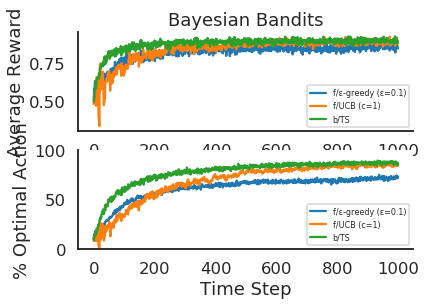

In [19]:
#Experiment with Bernoulli bandit
bandit = BernoulliBandit(n_arms, t=3*n_trials) 
agents = [
    Agent(bandit, EpsilonGreedyPolicy(0.1)), 
    Agent(bandit, UCBPolicy(1)),
    BetaAgent(bandit, GreedyPolicy())    #Thompson Sampling
]
env = Environment(bandit, agents, label='Bayesian Bandits')
scores, optimal = env.run(n_trials, n_experiments)
env.plot_results(scores, optimal)

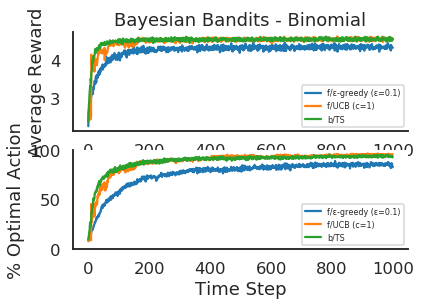

In [20]:
#Experiment with Binomial bandit
bandit = BinomialBandit(n_arms, n=5, t=3*n_trials)
agents = [
    Agent(bandit, EpsilonGreedyPolicy(0.1)),
    Agent(bandit, UCBPolicy(1)),
    BetaAgent(bandit, GreedyPolicy())
]
env = Environment(bandit, agents, label='Bayesian Bandits - Binomial')
scores, optimal = env.run(n_trials, n_experiments)
env.plot_results(scores, optimal)

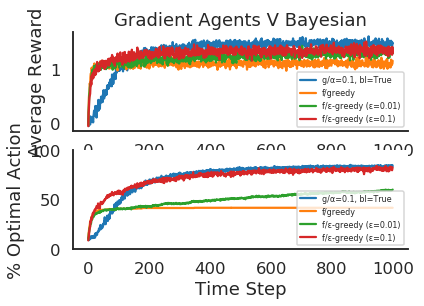

In [21]:
#Experiment with Gaussian bandit
bandit = GaussianBandit(n_arms)
agents = [
    GradientAgent(bandit, SoftmaxPolicy(), alpha=0.1),
    Agent(bandit, GreedyPolicy()),
    Agent(bandit, EpsilonGreedyPolicy(0.01)),
    Agent(bandit, EpsilonGreedyPolicy(0.1))
]
env = Environment(bandit, agents, 'Gradient Agents V Bayesian')
scores, optimal = env.run(n_trials, n_experiments)
env.plot_results(scores, optimal)